# Positive-Unlabeled learning vs One-Class classification

Example of using PU learning from the https://www.eecs.wsu.edu/~holder/courses/CptS570/fall09/present/ElkanKDD08.pdf paper as an application task for JetBrains Research internship in summer 2020.

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline

**PU classifier realization**

Classifier based on LogisticRegression

In [2]:
class PU_classifier:
    
    def __init__(self):
        self.c = 0 # p(s = 1| y = 1)
        self.nontraditional_clf = LogisticRegression() # Classifier label/unlabel
    
    def fit(self, labeled, unlabeled):
        labeled_train, labeled_test = train_test_split(labeled)
        
        X_train = np.concatenate([labeled_train, unlabeled])
        y_train = np.concatenate([np.ones(len(labeled_train)), np.zeros(len(unlabeled))])
        
        X_test = labeled_test
        y_test = np.ones(len(X_test))
        
        self.nontraditional_clf.fit(X_train, y_train)

        predictions = self.nontraditional_clf.predict_proba(X_test)[:, 1]
        self.c = sum(predictions)/len(predictions)
        
    def predict_proba(self, X):
        nontraditional_predict = self.nontraditional_clf.predict_proba(X)[:, 1]
        pos_predict = nontraditional_predict / self.c
        neg_predict = 1 - pos_predict
        
        return np.array(list(zip(neg_predict, pos_predict)))
    
    def predict(self, X, treshold=0.5):
        proba_predict = self.predict_proba(X)
        class_predict = list(map(int, proba_predict[:, 1] > treshold))
        
        return np.array(class_predict)
    
    def get_weight(self, x):
        prediction = self.nontraditional_clf.predict_proba(x)[0][1]
        
        comp1 = (1 - self.c)/self.c
        comp2 = prediction / (1 - prediction)
        
        return comp1*comp2
        
    def weight_fit(self, labeled, unlabeled):
        self.fit(labeled, unlabeled)
        
        X_train = labeled
        y_train = np.ones(len(labeled))
        weights = np.ones(len(labeled))

        for idx, x in enumerate(unlabeled):
            weight = self.get_weight([x])
            
            X_train = np.append(X_train, [x, x])
            y_train = np.append(y_train, [1, 0])
            weights = np.append(weights, [weight, 1-weight])

        X_train = X_train.reshape((-1, labeled.shape[1]))
        self.nontraditional_clf.fit(X_train, y_train, sample_weight=weights)

        predictions = self.nontraditional_clf.predict_proba(labeled)[:, 1]
        self.c = sum(predictions)/len(predictions)

**Data synthesizing**

`get_data` - Generates data with Gaussians

`pu_separation` - Separates initial data to labeled and unlabeled

`add_dimension` - Create new features for model to create ellipsoids

In [23]:
def get_data(size=1000, frac=0.2, center=(0, 0), cov=((2, 0), (0, 10))):
    # Generates sample data of given size with 'frac' size of one class and '1-frac' of another 
    
    radius = np.random.randint(4, 6)
    center2 = np.array(center) + np.array([radius, radius])
    cov2 = cov[::-1]

    data1 = np.random.multivariate_normal(mean=center, cov=cov, size=int(size*frac))
    data2 = np.random.multivariate_normal(mean=center2, cov=cov, size=int(size*(1-frac)))
    
    X = np.concatenate([data1, data2])
    y = np.concatenate([np.ones(len(data1)), np.zeros(len(data2))])
    
    return X, y

def pu_separation(data, pos_indexes, frac=0.2):
    # Separates data into two classes: labeled and unlabeled
    # in labeled class may lie only examples of one class
    size = int(len(pos_indexes) * frac)
    
    labeled_idx = np.array(np.random.choice(pos_indexes, size=size), dtype=int)
    unlabeled_idx = np.array([idx for idx in range(len(data)) if idx not in labeled_idx])
    
    labeled = data[labeled_idx, :]
    unlabeled = data[unlabeled_idx, :]
    
    return labeled, unlabeled

def add_dimension(x_sample):
    shapes = list(x_sample.shape)
    shapes[1] += 3
    
    temp = np.zeros(shapes)
    temp[:, :-3] = x_sample
    
    temp[:, -3] = temp[:, 0] ** 2
    temp[:, -2] = temp[:, 1] ** 2
    temp[:, -1] = temp[:, 0] * temp[:, 1]
    
    return temp
    

In [24]:
x_sample, y_sample = get_data()
x_sample = add_dimension(x_sample)

pos_indexes = [idx for idx, val in enumerate(y_sample) if val == 1]
neg_indexes = [idx for idx, val in enumerate(y_sample) if val == 0]

labeled, unlabeled = pu_separation(x_sample, pos_indexes)

**Models**

Create two kinds of models:

- **PU_classifier** (based on Logistic Regression)

- **LogisticRegression**

Train models:

- **PU_classifier** on labeled/unlabeled data

- **LogisticRegression** on some training set of positive/negative data

In [25]:
pu_clf = PU_classifier()
lr_clf = LogisticRegression()

pu_clf.weight_fit(labeled,unlabeled)
lr_clf.fit(x_sample, y_sample)

pu_predictions = pu_clf.predict(x_sample)
lr_predictions = lr_clf.predict(x_sample)

**Plotting**

In [26]:
def scatter(data, indexes, ax, title, markers, colors):
    ax.set_title(title)
    
    for idx, m, c in zip(indexes, markers, colors):
        ax.scatter(data[idx, 0], data[idx, 1], c=c, marker=m)

def plot_levels(ax, clf):
    x_left, x_right = ax.get_xlim()
    y_left, y_right = ax.get_ylim()
    xx, yy = np.mgrid[x_left:x_right:.1, y_left:y_right:.1]

    grid = np.c_[xx.ravel(), yy.ravel()]
    grid = add_dimension(grid)

    probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
    ax.contour(xx, yy, probs, linestyles='dashed', levels=1)

In [27]:
lr_pos_classes = [idx for idx, val in enumerate(lr_predictions) if val == 1]
lr_neg_classes = [idx for idx, val in enumerate(lr_predictions) if val == 0]

pu_pos_classes = [idx for idx, cl in enumerate(pu_predictions) if cl == 1]
pu_neg_classes = [idx for idx, cl in enumerate(pu_predictions) if cl == 0]

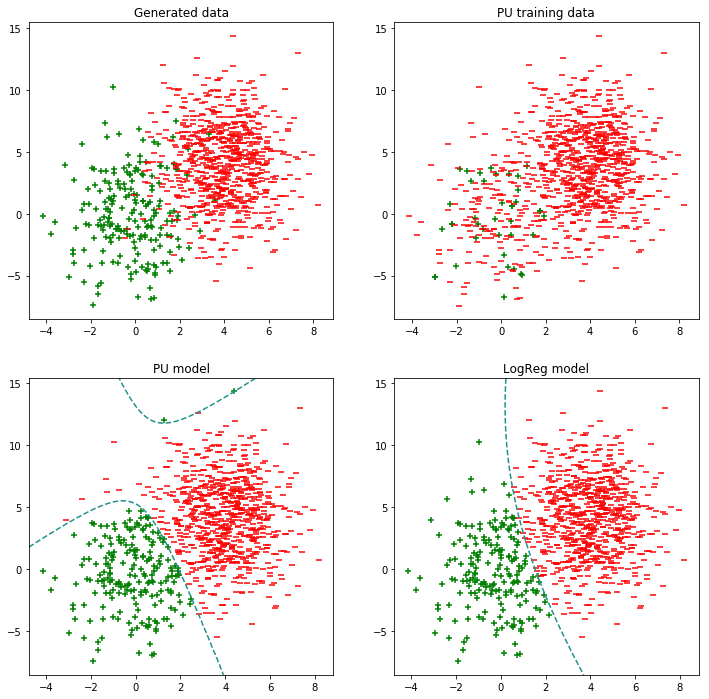

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

# Plot generated data with classes
scatter(x_sample, [pos_indexes, neg_indexes], ax1, 'Generated data', ['+', '_'], ['g', 'r'])

# Plot training data for PU classifier
ax2.set_title('PU training data')
ax2.scatter(labeled[:, 0], labeled[:, 1], c='g', marker='+')
ax2.scatter(unlabeled[:, 0], unlabeled[:, 1], c='r', marker='_')

# Plot predicted values of PU classifier & levels
scatter(x_sample, [pu_pos_classes, pu_neg_classes], ax3, 'PU model', ['+', '_'], ['g', 'r'])
plot_levels(ax3, pu_clf)

# Plot predicted values of pretrained LogisticRegression
scatter(x_sample, [lr_pos_classes, lr_neg_classes], ax4, 'LogReg model', ['+', '_'], ['g', 'r'])
plot_levels(ax4, lr_clf)

plt.savefig('classification_result.jpg')
plt.show()

**Metrics**

In [29]:
print('Classification report:')
print(classification_report(pu_predictions, y_sample))
print('-'*80)
print('Confusion matrix:')
print(confusion_matrix(pu_predictions, y_sample))

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       796
           1       0.88      0.86      0.87       204

    accuracy                           0.95      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.95      0.95      0.95      1000

--------------------------------------------------------------------------------
Confusion matrix:
[[772  24]
 [ 28 176]]


In [30]:
print('Classification report:')
print(classification_report(lr_predictions, y_sample))
print('-'*80)
print('Confusion matrix:')
print(confusion_matrix(lr_predictions, y_sample))

Classification report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       806
         1.0       0.89      0.92      0.90       194

    accuracy                           0.96      1000
   macro avg       0.94      0.95      0.94      1000
weighted avg       0.96      0.96      0.96      1000

--------------------------------------------------------------------------------
Confusion matrix:
[[784  22]
 [ 16 178]]
